# Load Data

In [1]:
from os import listdir
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filepaths = glob.glob("../data/tidy/albumin/*_events_*.csv")
df = pd.concat(map(pd.read_csv, filepaths))
df["CLINICAL_EVENT_DATETIME"] = pd.to_datetime(df["CLINICAL_EVENT_DATETIME"])
df.index = df["CLINICAL_EVENT_DATETIME"]

In [3]:
df_daily = df.resample("D").count()[["EVENT_ID"]]
df_daily.columns = ["Doses"]

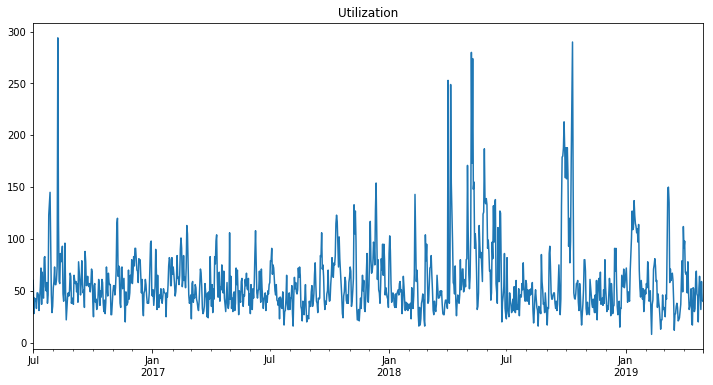

In [4]:
ax = df_daily.plot(legend=False, figsize=(12, 6), title="Utilization")
ax.autoscale(axis='x',tight=True)
ax.set(xlabel="");

In [20]:
actual_val = df_daily["Doses"].tail(7)

# ACF

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import lag_plot

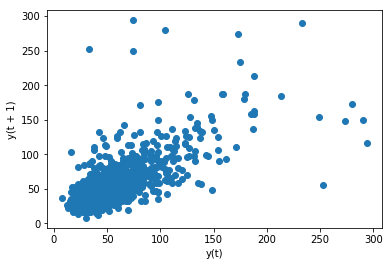

In [6]:
lag_plot(df_daily["Doses"]);

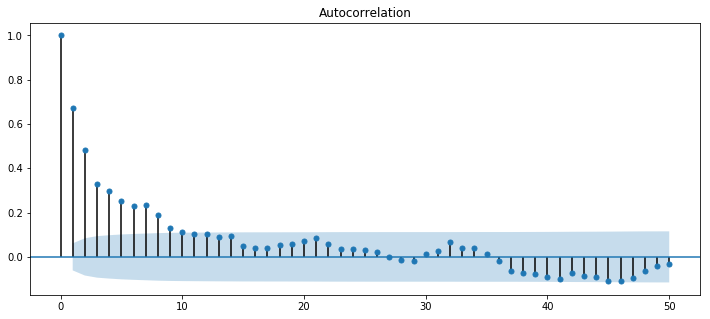

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(df_daily["Doses"], lags=50, ax=ax);
#plot_acf(df_daily);

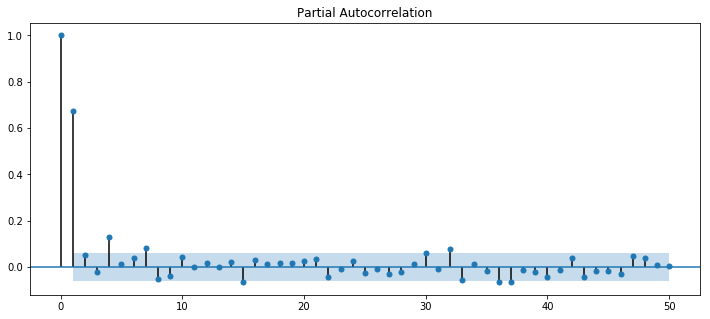

In [10]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(df_daily["Doses"].dropna(), lags=50, ax=ax);

In [8]:
# data is stationary if p-value < 0.05
adfuller(df_daily["Doses"].dropna(), autolag='AIC')[1]

1.5246616119526778e-11

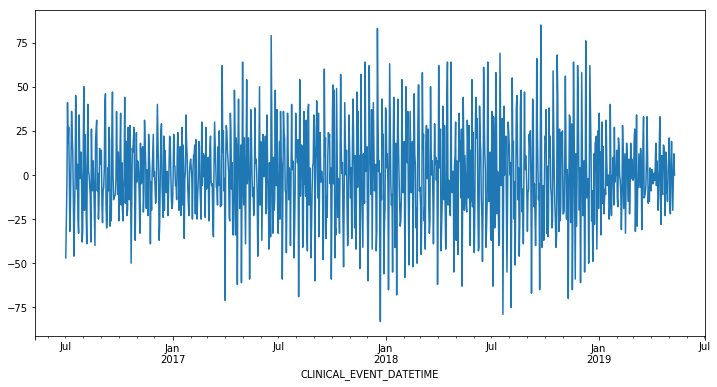

In [145]:
# difference the data to make it stationary
df_diff = df_daily.copy()
df_diff["Doses"] = diff(df_daily["Doses"], k_diff=1)
df_diff["Doses"].plot(figsize=(12, 6))

In [131]:
adfuller(df_diff["Doses"].dropna(), autolag='AIC')[1]

1.5148299312929528e-27

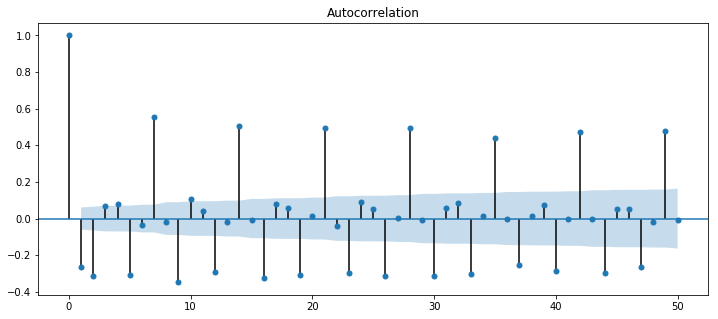

In [132]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(df_diff["Doses"].dropna(), lags=50, ax=ax);

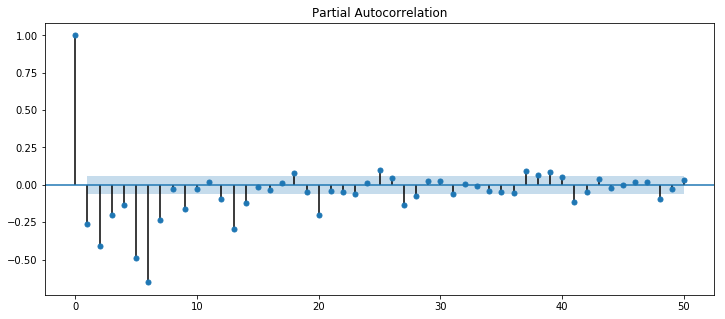

In [133]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(df_diff["Doses"].dropna(), lags=50, ax=ax);

# AR(p) Model

In [11]:
n_pred = 30
l = len(df_daily) - n_pred
train_set = df_daily.iloc[:l]
test_set = df_daily.iloc[l:]

In [12]:
from statsmodels.tsa.ar_model import AR, ARResults
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [13]:
model_ar = AR(train_set["Doses"])
fit_ar = model_ar.fit(method="cmle")
print(f'Lag: {fit_ar.k_ar}')

Lag: 21


In [14]:
preds_ar = fit_ar.predict(start=len(train_set), end=len(df_daily) - 1, dynamic=False).rename('AR Predictions')

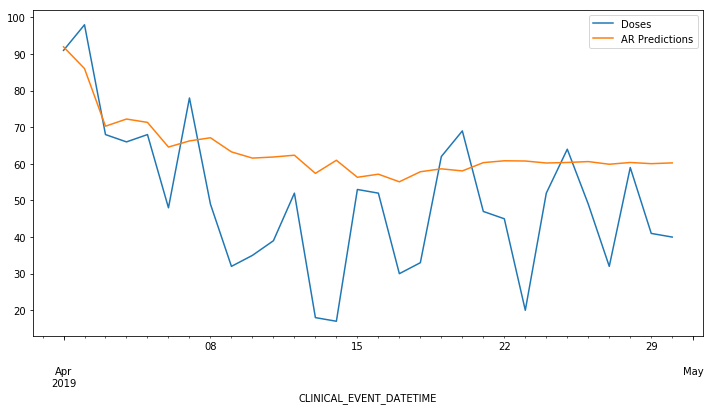

In [15]:
test_set["Doses"].plot(legend=True)
preds_ar.plot(legend=True, figsize=(12, 6));

In [16]:
print(f'MSE: {mean_squared_error(test_set["Doses"], preds_ar):11.10}')
print(f'RMSE: {rmse(test_set["Doses"], preds_ar):11.10}')
print(f'AIC: {fit_ar.aic:6.5}')

MSE: 400.6920692
RMSE: 20.01729425
AIC:  6.459


## AR Forecast

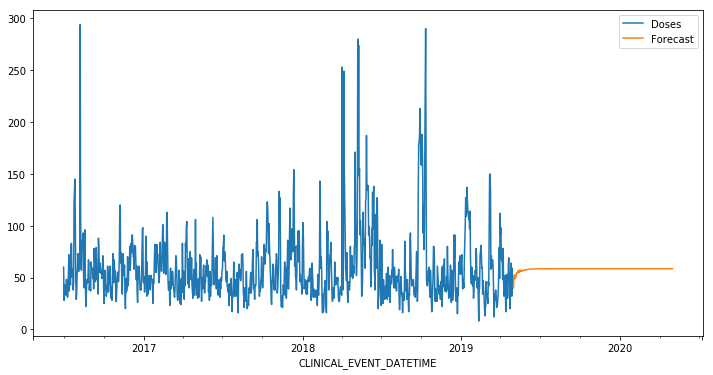

In [17]:
model_ar = AR(df_daily["Doses"])
fit_ar = model_ar.fit(maxlag=21, method="cmle")
preds_ar = fit_ar.predict(start=len(df_daily), end=len(df_daily) + 365, dynamic=False).rename('Forecast')
df_daily["Doses"].plot(legend=True)
preds_ar.plot(legend=True, figsize=(12, 6));

# ARIMA Models

In [18]:
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from pmdarima import auto_arima

In [19]:
auto_mod = auto_arima(
    df_daily["Doses"], 
    seasonal=False, 
    stepwise=False,
    maxitr=100, 
    suppress_warnings=True,
    error_action="ignore"
)
auto_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1034
Model:                     ARMA(3, 5)   Log Likelihood               -4769.389
Method:                       css-mle   S.D. of innovations             24.355
Date:                Thu, 23 May 2019   AIC                           9558.778
Time:                        15:21:21   BIC                           9608.190
Sample:                             0   HQIC                          9577.527
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.5090      3.891     15.039      0.000      50.884      66.134
ar.L1.y        0.4889      0.021     23.528      0.000       0.448       0.530
ar.L2.y       -0.5816      0.009    -63.932      0.000      -0.599      -0.564
ar.L3.y        0.9312      0.020     45.766      0.000       0.891       0.971
ma.L1.y        0.1490      0.037      4.046      0.000       0.077       0.221
ma.L2.y        0.7432      0.038     19.445      0.000       0.668       0.818
ma.L3.y       -0.5890      0.056    -10.431      0.000      -0.700      -0.478
ma.L4.y       -0.2215      0.039     -5.726      0.000      -0.297      -0.146
ma.L5.y       -0.2433      0.036     -6.697      0.000      -0.315      -0.172
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2231           -0.9763j            1.0014           -0.2858
AR.2           -0.2231           +0.9763j            1.0014            0.2858
AR.3            1.0709           -0.0000j            1.0709           -0.0000
MA.1            1.2338           -0.0000j            1.2338           -0.0000
MA.2           -0.2251           -0.9805j            1.0060           -0.2859
MA.3           -0.2251           +0.9805j            1.0060            0.2859
MA.4           -0.8469           -1.6044j            1.8142           -0.3273
MA.5           -0.8469           +1.6044j            1.8142            0.3273
-----------------------------------------------------------------------------
"""

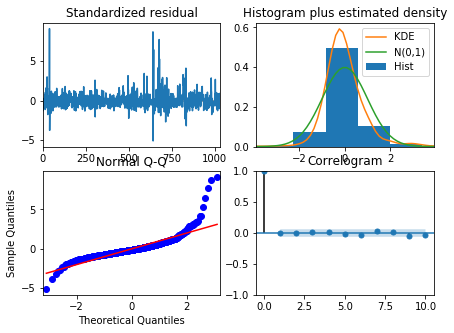

In [20]:
auto_mod.plot_diagnostics(figsize=(7,5))
plt.show()

In [26]:
mod_order = (3, 0, 5)

In [22]:
model_arima = ARIMA(train_set["Doses"], order=mod_order)
fit_arima = model_arima.fit()
#print(fit_arima.summary())

/home/brian/anaconda3/envs/tsa_course/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [23]:
fc, se, conf = fit_arima.forecast(n_pred, alpha=0.05)  # 95% conf
fc_series = pd.Series(fc, index=test_set.index)
lower_series = pd.Series(conf[:, 0], index=test_set.index)
upper_series = pd.Series(conf[:, 1], index=test_set.index)

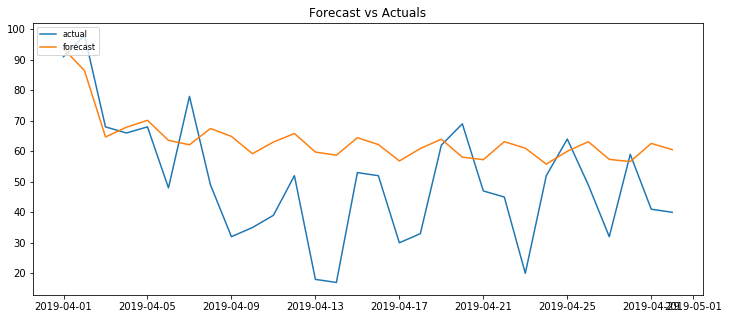

In [24]:
plt.figure(figsize=(12, 5))
#plt.plot(train_set, label='training')
plt.plot(test_set, label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [25]:
print(f'MSE: {mean_squared_error(test_set["Doses"], fc_series):11.10}')
print(f'RMSE: {rmse(test_set["Doses"], fc_series):11.10}')

MSE: 421.7668393
RMSE: 20.53696276


In [27]:
model_arima = ARIMA(df_daily["Doses"], order=mod_order)
fit_arima = model_arima.fit()
#preds_arima = fit_arima.predict(start=len(df_daily), end=len(df_daily) + 30, dynamic=False).rename('Forecast')

In [28]:
n_pred = 90
fc, se, conf = fit_arima.forecast(n_pred, alpha=0.05)  # 95% conf
idx = pd.date_range(df_daily.index[-1] + 1, periods = n_pred, freq="D")
fc_series = pd.Series(fc, index=idx)
lower_series = pd.Series(conf[:, 0], index=idx)
upper_series = pd.Series(conf[:, 1], index=idx)

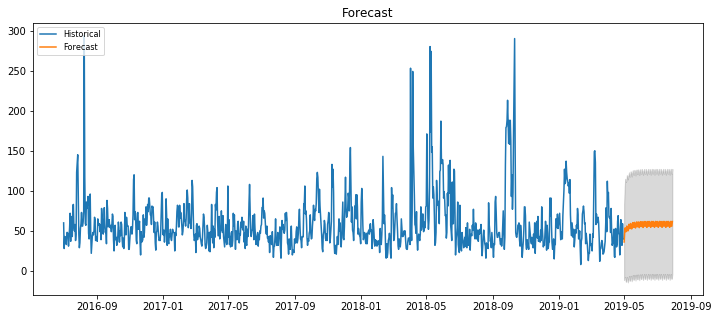

In [29]:
#df_daily["Doses"].plot(legend=True)
#preds_arima.plot(legend=True, figsize=(12, 6));
plt.figure(figsize=(12, 5))
plt.plot(df_daily, label='Historical')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()